In [1]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8
import decord
from decord import cpu, gpu
import numpy as np
import torchvision.transforms as T
import ast

2023-11-22 16:56:40.425928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 16:56:40.425988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 16:56:40.427191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 16:56:40.435067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 16:56:41.721204: W tensorflow/comp

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device, device2)

cuda:0 cuda:1


In [3]:
def get_video(video_path, fps=30):
        # If fixed width and height are required, VideoReader takes width and height as arguments.
        video_reader = decord.VideoReader(str(video_path), num_threads=1, ctx=cpu(0))
        decord.bridge.set_bridge('torch')
        vlen = len(video_reader)
        print(vlen)
        original_fps = video_reader.get_avg_fps()
        print(original_fps)
        num_frames = int(vlen * fps / original_fps)
        # num_frames = min(self.max_num_frames, num_frames)
        frame_idxs = np.linspace(0, vlen, num_frames, endpoint=False).astype(np.int_)
        video = video_reader.get_batch(frame_idxs).byte()
        video = video.permute(0, 3, 1, 2)
        return video

In [4]:
video_id = 3489439407
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')
video.shape

1662
29.97002997002997


torch.Size([1663, 3, 480, 640])

In [25]:

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["lady in blue standing listening to her headphones"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

Image features shape:  torch.Size([167, 1152]) Text features shape:  torch.Size([1, 1152])


75/270


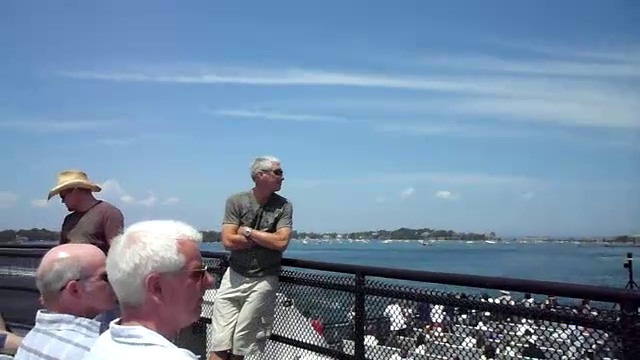

In [109]:
raw_image = images[indices[0][0].item() - 150]
print(f"{indices[0][0].item()}/{len(images)}")
raw_image

In [26]:
from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
# preprocess the image
# vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
# generate caption
model.generate({"image": image})
# ['a large fountain spewing water into the air']

NameError: name 'raw_image' is not defined

In [ ]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device2)
# ask a random question.
question = "What is the man doing in the video?"
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
question = txt_processors["eval"](question)
model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")

['watching tv']

In [ ]:
import openai

with open('api.key') as f:
    openai.api_key = f.read().strip()
with open('api_org.key') as f:
    openai.organization = f.read().strip()

def call_llm(prompt):
    completion = openai.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "Follow the directions given in the next prompt carefully."},
        {"role": "user", "content": prompt}
      ]
    )
    output_message = completion.choices[0].message.content
    return output_message


In [ ]:
def get_answer_helper(question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
    with open('./prompts/base_prompt.txt') as f:
        prompt = f.read()
    prompt = prompt.replace('insert_question', question)
    prompt = prompt.replace('insert_choices', str(answer_choices))
    prompt = prompt.replace('insert_curr_frame', str(curr_frame))
    prompt = prompt.replace('insert_total_frames', str(total_frames))
    prompt = prompt.replace('insert_caption', caption[0])

    #print(prompt)
    output = call_llm(prompt)
    try:
        output_dict = ast.literal_eval(output)
        print("GETTING OUTPUT: ", output_dict)
        return output_dict
    except:
        print("ERROR: ", output)

In [33]:
def query_VQA(vqa_question, frame):
    print("CALLING VQA: ", vqa_question)
    model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device2)
    # ask a random question.
    question = vqa_question
    image = vis_processors["eval"](frame).unsqueeze(0).to(device2)
    question = txt_processors["eval"](question)
    answer = model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")
    print("VQA ANSWER: ", answer)
    return answer

In [38]:
def query_caption(frame):
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](frame).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    return caption

In [68]:
def get_answer(images, question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
    LIMIT = 10
    goto_frame = curr_frame
    VQA_question = None
    info = {}
    caption = caption
    while LIMIT >= 0:
        print(f"CALL {10 - LIMIT}")
        print("ALL INFO:", info)
        if f"Frame {goto_frame}" not in info:
            info[f"Frame {goto_frame}"] = {}
        LIMIT -= 1  
        if goto_frame != None:
            raw_image = images[goto_frame] 
        caption = query_caption(raw_image)
        print(caption)
        output = get_answer_helper(question, answer_choices, goto_frame, total_frames, caption, prev_info)
        print(output)
        if output["Answer"] != None:
            print("here1")
            return output["Answer"]
        else:
            info[f"Frame {goto_frame}"]["caption"] = caption
            if output["Choose Frame"] != None:
                goto_frame = output["Choose Frame"]
            if output["VQA Question"] != None:
                VQA_question = output["VQA Question"]
                vqa_result = query_VQA(VQA_question, raw_image)
                info[f"Frame {curr_frame}"][VQA_question] = vqa_result
            else:
                continue       
    # case for when we run out of tries
    
             

In [60]:
def answer_question(vid_id, quest, option_choices, query):
    video_id = vid_id
    question = quest
    options = option_choices
    video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

    model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    model = model.to(device)
    preprocess = preprocess
    tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

    transform = T.ToPILImage()
    sampling_rate = 10
    images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

    labels_list = query
    image_stack = torch.stack([preprocess(image) for image in images]).to(device)
    text = tokenizer(labels_list, context_length=model.context_length).to(device)


    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_stack)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

        text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

    values, indices = torch.topk(text_probs, 3)

    raw_image = images[indices[0][0].item()]
    print(f"{indices[0][0].item()}/{len(images)}")

    from lavis.models import load_model_and_preprocess
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    print(caption)
    raw_image.show()
    result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
    return result

In [64]:
def answer_question_half(vid_id, quest, option_choices, query):
    video_id = vid_id
    question = quest
    options = option_choices
    video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

    model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    model = model.to(device)
    preprocess = preprocess
    tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

    transform = T.ToPILImage()
    sampling_rate = 10
    images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

    labels_list = query
    image_stack = torch.stack([preprocess(image) for image in images]).to(device)
    text = tokenizer(labels_list, context_length=model.context_length).to(device)


    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_stack)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

        text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

    values, indices = torch.topk(text_probs, 3)

    raw_image = images[indices[0][0].item()]
    print(f"{indices[0][0].item()}/{len(images)}")

    from lavis.models import load_model_and_preprocess
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    print(caption)
    raw_image.show()
    return images, caption, indices[0][0].item(), len(images)
    #result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
    #return result

# Q1

2697
29.97002997002997
Image features shape:  torch.Size([270, 1152]) Text features shape:  torch.Size([1, 1152])
75/2699
['a group of men standing next to each other on a bridge']


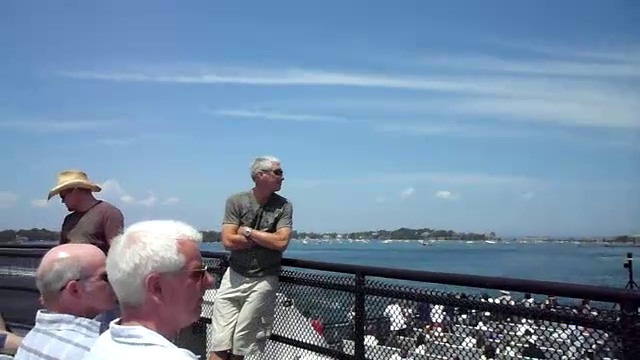

In [85]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["lady in blue standing listening to her headphones"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

raw_image = images[indices[0][0].item() - 150]
print(f"{indices[0][0].item()}/{images.shape[0]}")

from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
caption = model.generate({"image": image})
print(caption)
raw_image

In [146]:
result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
result

{'Enough Information?': True, 'Answer': 0, 'Choose Frame': None, 'VQA Question': None}


0

# Q2

369
29.97002997002997
3/37
['a group of young men playing guitars on stage']


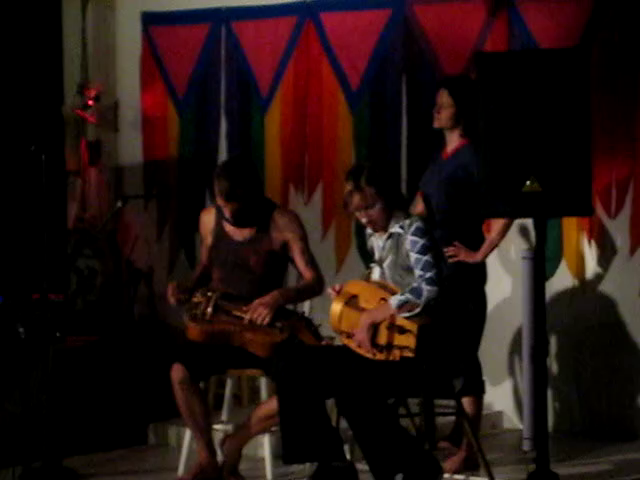

In [72]:
video_id = 4010069381
question = "why does the lady walks away after the conversation with man is over?"
options = ['pick up phone', 'enjoying stroll', 'giving her space to perform', 'help man do something else', 'performance ended']

images, caption = answer_question_half(video_id, question, options, "lady walking away")

In [73]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

CALL 0
ALL INFO: {}


['a group of young men playing guitars on stage']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 10, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 10, 'VQA Question': None}
CALL 1
ALL INFO: {'Frame 3': {'caption': ['a group of young men playing guitars on stage']}}
['a group of people standing around a man holding a guitar']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': -5, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': -5, 'VQA Question': None}
CALL 2
ALL INFO: {'Frame 3': {'caption': ['a group of young men playing guitars on stage']}, 'Frame 10': {'caption': ['a group of people standing around a man holding a guitar']}}
['a man sitting in a chair playing a guitar']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 5, 'VQA Question': 'What is the lady holding in her hand?'}
{'Enough Information?': False, 'Answer':

4

# Q3

2697
29.97002997002997
2697
29.97002997002997
37/270
['a view of a harbor with a boat in the water']


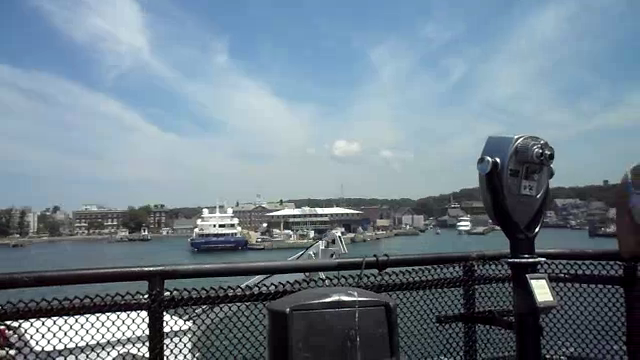

In [74]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "location of the image")

In [75]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

CALL 0
ALL INFO: {}
['a man standing next to a large body of water']
GETTING OUTPUT:  {'Enough Information?': True, 'Answer': 0, 'Choose Frame': None, 'VQA Question': None}
{'Enough Information?': True, 'Answer': 0, 'Choose Frame': None, 'VQA Question': None}
here1


0

# Q4

In [ ]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "location of the image")

In [ ]:
0,2194,"['turns around', 'working on the radio', 'moving the papers', 'walk forward', 'choosing a flower']",,what are the two men doing as the lady in blue stands and listen via her headphone?,1,3489439407.mp4